# Visualizing registration experiment runs

Plot results from the registration runs with random initializations.

To run the registration experiment, run the following in the home directory:

```python experiments/registration/registration.py --n_drrs=1000```

In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import pandas as pd

from src import read_dicom, DRR
from src.visualization import plot_drr

custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params)
colors = {True: "#e7298a", False: "#7570b3"}

def converged(df):
    return df["loss"].iloc[-1] <= -0.999

Achieved convergence: 70.50% in 4.16±1.67s on average


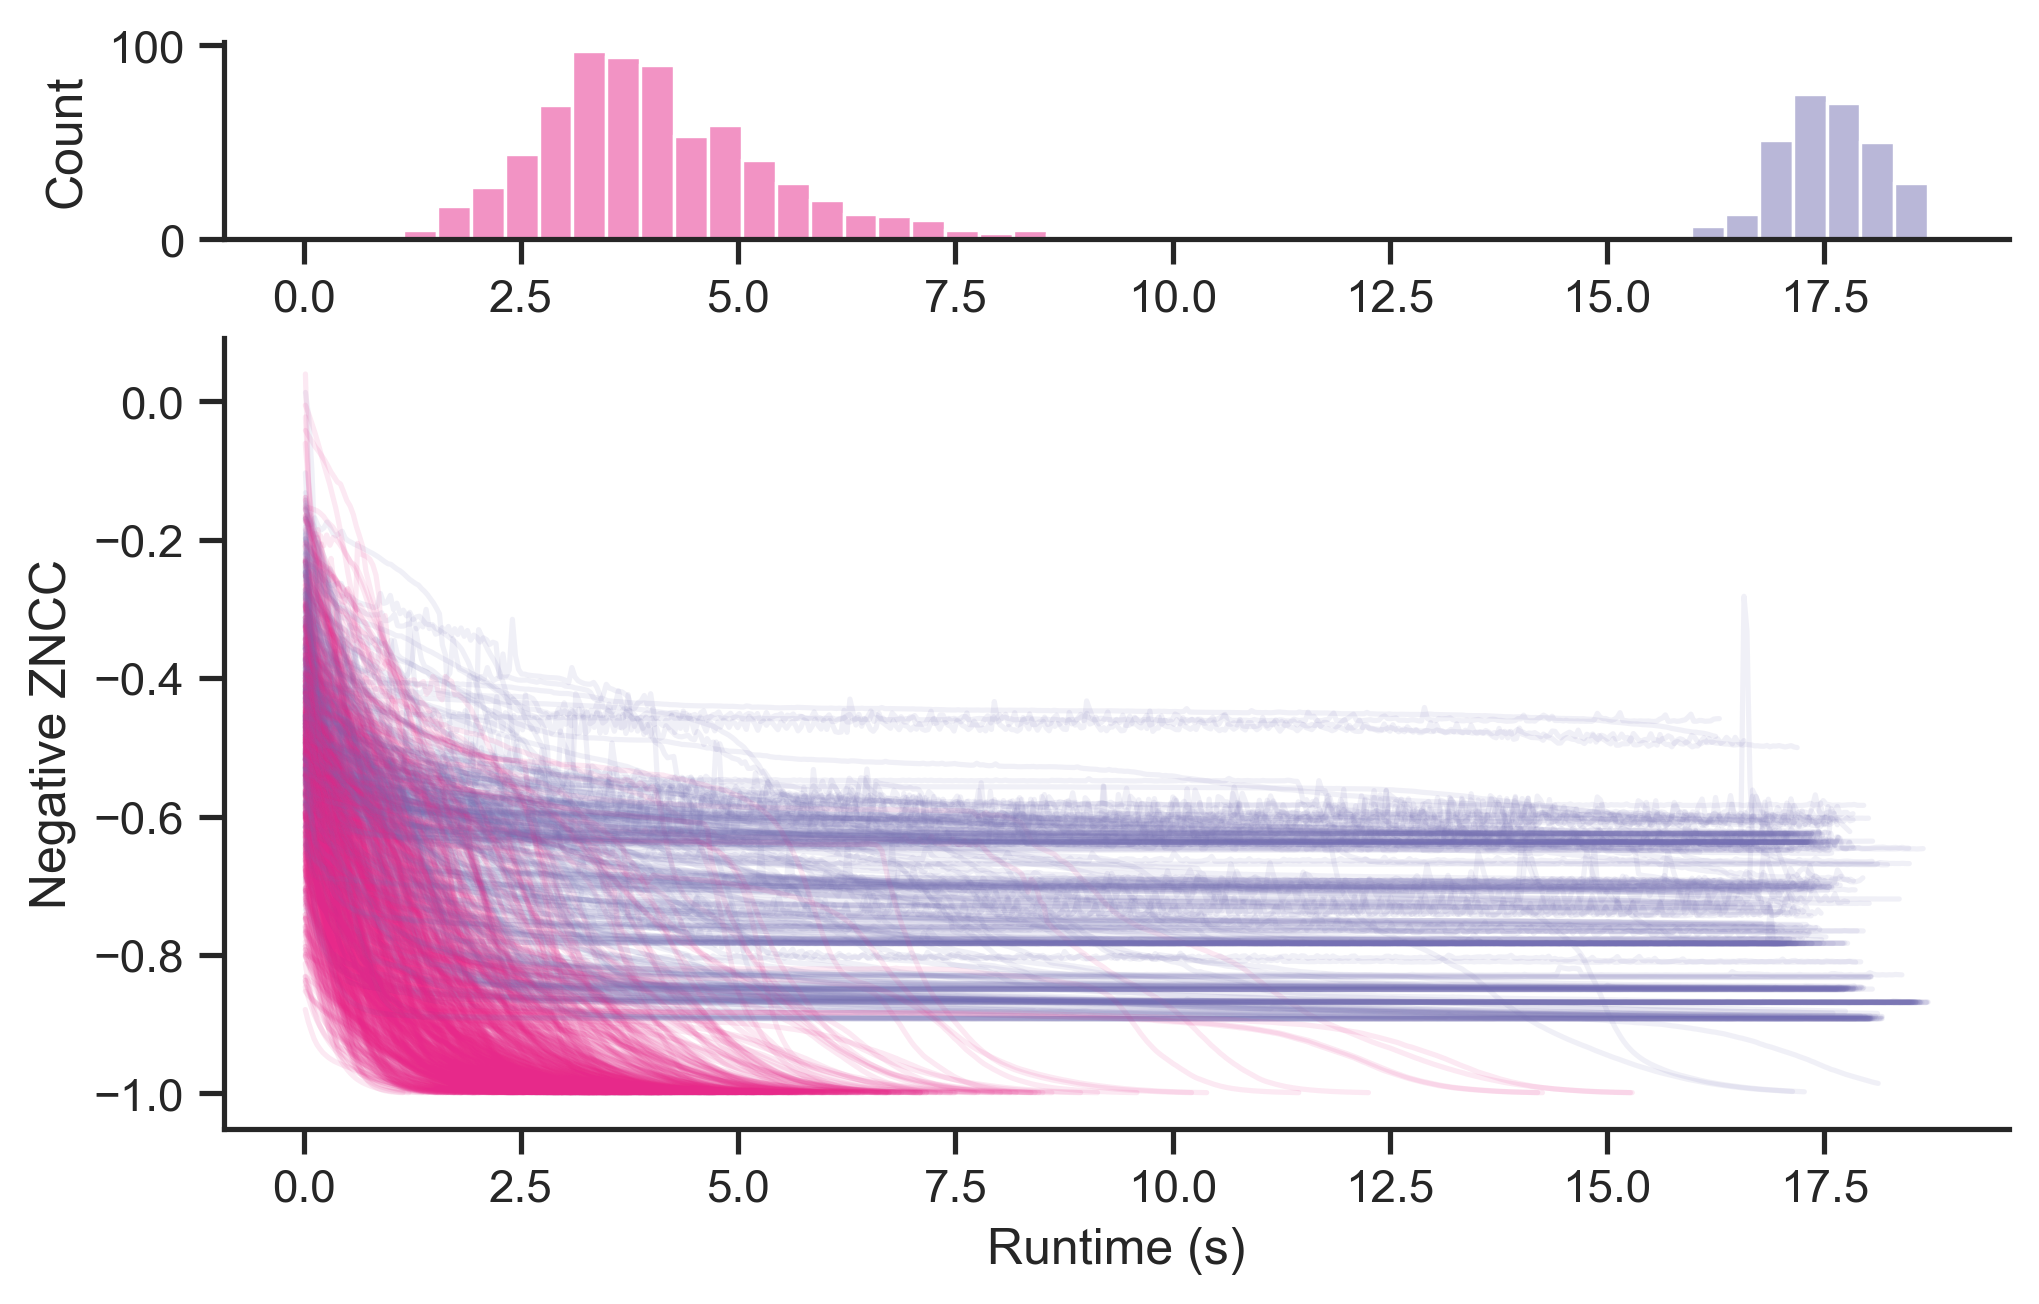

In [2]:
fig = plt.figure(dpi=300, figsize=plt.figaspect(5/8))
gs = gridspec.GridSpec(nrows=2, ncols=1, height_ratios=[1, 4], figure=fig)
ax_hist = plt.subplot(gs[0])
ax_plot = plt.subplot(gs[1], sharex=ax_hist)

# Plot the training trajectories
dfs = []
kwargs = {"alpha": 0.1, "lw": 1.25}
for file in Path("registration_results/").glob("*.csv"):
    df = pd.read_csv(file)
    df["runtime"] = df["time"].cumsum()
    df["converged"] = converged(df)
    color = colors[converged(df)]
    ax_plot.plot(df["runtime"], df["loss"], color, **kwargs)
    dfs.append(df.iloc[-1])
ax_plot.set(xlabel="Runtime (s)", ylabel="Negative ZNCC")

# Plot the convergence timing histogram
df = pd.concat(dfs, axis=1).T.reset_index(drop=True)
sns.histplot(data=df, x="runtime", hue="converged", palette=colors, legend=False, bins=45, ax=ax_hist)
ax_hist.set(xlabel=None)

p_conv = df["converged"].astype(int).sum() / len(df)
t_conv = df.query("converged == True")["runtime"].mean()
s_conv = df.query("converged == True")["runtime"].std()
print(f"Achieved convergence: {p_conv:.2%} in {t_conv:.2f}±{s_conv:.2f}s on average")
plt.show()

In [3]:
# Utility functions for plotting DRRs
volume, spacing = read_dicom("../data/cxr")
drr = DRR(volume, spacing, height=100, delx=5e-2, device="cpu")


def plot_df(df, idx=-1, ax=None):
    """Plot the DRR at a specific iteration."""
    params = df.iloc[idx][["theta", "phi", "gamma", "bx", "by", "bz"]].values
    sdr = 200
    img = drr(sdr, *params)
    plot_drr(img, ax=ax)
    
    
def plot_start_stop(df):
    """Plot the first and last iterations."""
    fig, axs = plt.subplots(ncols=2)
    plot_df(df, 0, axs[0])
    plot_df(df, -1, axs[1])
    plt.show()